# Creating the Model for Prediction and Classification

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [111]:
raw_dataset = pd.read_csv("./Output/New_Dataset/Processed_Dataset2.csv")
raw_dataset.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
0,83.13,107.67,6.93,28.71,33.72,17.055,6.93,49.52,59.76,0.02,0.00,209.0
1,79.84,107.67,13.85,28.68,41.08,17.055,13.85,48.49,97.07,0.04,0.00,328.0
2,94.52,107.67,24.39,32.66,52.61,17.055,24.39,67.39,111.33,0.24,0.01,514.0
3,135.99,107.67,43.48,42.08,84.57,17.055,43.48,75.23,102.70,0.40,0.04,782.0
4,178.33,107.67,54.56,35.31,72.80,17.055,54.56,55.04,107.38,0.46,0.06,914.0


In [112]:
dataset = raw_dataset.copy()

# Create a column that contains the labelled AQI that will be appended into the dataset
# The categories are based on this: https://www.airnow.gov/aqi/aqi-basics/
# With 0 = Good, 1 = Moderate, 2 = Unhealthy for Sensitive Groups, 3 = Unhealthy, 4 = Very Unhealthy, 5 = Hazardous
AQI_Label = []

for val in dataset["AQI"]:
    if val >= 0 and val <= 50:
        AQI_Label.append(0)
    elif val > 50 and val <= 100:
        AQI_Label.append(1)
    elif val > 100 and val <= 150:
        AQI_Label.append(2)
    elif val > 150 and val <= 200:
        AQI_Label.append(3)
    elif val > 200 and val <= 300:
        AQI_Label.append(4)
    elif val > 300:
        AQI_Label.append(5)

dataset["AQI_Label"] = AQI_Label

# Remove the AQI since we're labelling it now
dataset.pop("AQI")
dataset.head()
    

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI_Label
0,83.13,107.67,6.93,28.71,33.72,17.055,6.93,49.52,59.76,0.02,0.00,4
1,79.84,107.67,13.85,28.68,41.08,17.055,13.85,48.49,97.07,0.04,0.00,5
2,94.52,107.67,24.39,32.66,52.61,17.055,24.39,67.39,111.33,0.24,0.01,5
3,135.99,107.67,43.48,42.08,84.57,17.055,43.48,75.23,102.70,0.40,0.04,5
4,178.33,107.67,54.56,35.31,72.80,17.055,54.56,55.04,107.38,0.46,0.06,5


<Axes: >

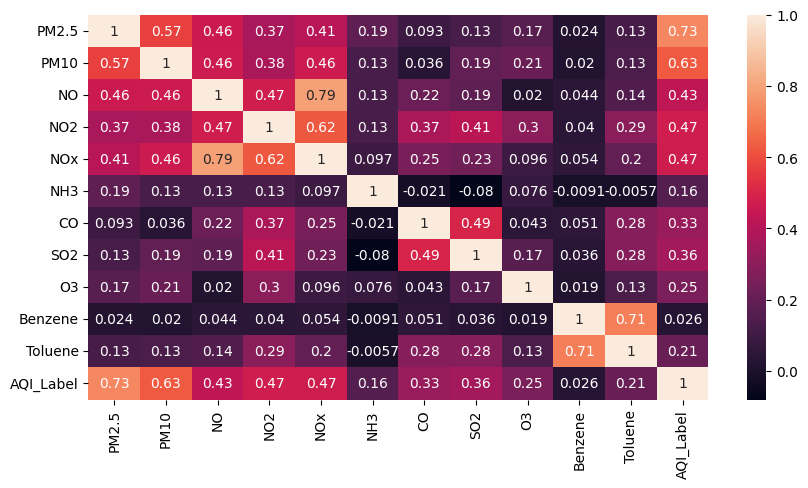

In [113]:
# # Visualize the correlation for these variables
plt.figure(figsize=(10,5))
sns.heatmap(dataset.corr(), annot=True)

In [114]:
dataset.pop("NH3")

0        17.055
1        17.055
2        17.055
3        17.055
4        17.055
          ...  
24845    12.470
24846    11.990
24847    10.710
24848    10.030
24849     5.200
Name: NH3, Length: 24850, dtype: float64

In [115]:
# Split the dataset with an 80/20 split for train and test and set the y (target) as the AQI_Label
x_train, x_test = train_test_split(dataset, test_size=0.2, random_state=42)
y_train = x_train.pop("AQI_Label")
y_test = x_test.pop("AQI_Label")

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print(x_train.shape)

(19880, 10)


In [116]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [117]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(x_train))
print(normalizer)

<Normalization name=normalization_9, built=True>


In [118]:
aqi_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(32, activation='relu', kernel_regularizer='l2'),
    layers.Dense(16, activation='relu'),
    layers.Dense(y_train.shape[1], activation="softmax")
])
aqi_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_9 (Normalization) │ (19880, 10)            │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (88.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21 (88.00 B)

In [119]:
aqi_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [120]:
history = aqi_model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10)
)

Epoch 1/100
497/497 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2375 - loss: 1.9531 - val_accuracy: 0.4530 - val_loss: 1.7663
Epoch 2/100
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4565 - loss: 1.7054 - val_accuracy: 0.5438 - val_loss: 1.5197
Epoch 3/100
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5447 - loss: 1.4730 - val_accuracy: 0.5516 - val_loss: 1.3671
Epoch 4/100
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5428 - loss: 1.3577 - val_accuracy: 0.5659 - val_loss: 1.2706
Epoch 5/100
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5666 - loss: 1.2504 - val_accuracy: 0.5883 - val_loss: 1.1891
Epoch 6/100
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5852 - loss: 1.1865 - val_accuracy: 0.6134 - val_loss: 1.1179
Epoch 7/100
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6135 - loss: 1.1049 - val_accuracy: 0.6346 - val_loss: 1.0591
Epoch 8/100
497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6317 - loss: 1.0522 - val_accu

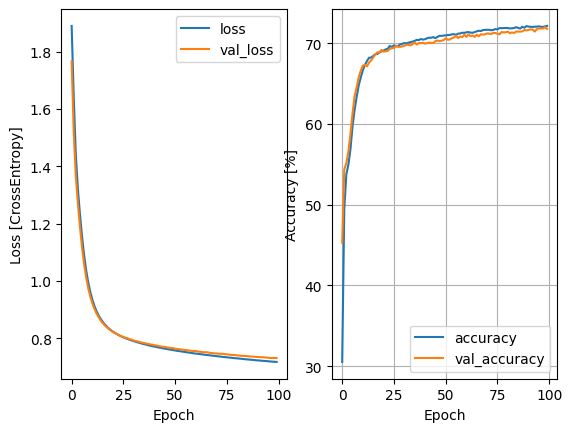

In [121]:
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history["loss"], history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.legend(["loss", "val_loss"])

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(history.history["accuracy"]), 100*np.array(history.history["val_accuracy"]))
plt.legend(["loss", "val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.legend(["accuracy", "val_accuracy"])
plt.grid(True)

In [122]:
test_results = aqi_model.evaluate(
    x_test,
    y_test
)

print(test_results)

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7281 - loss: 0.7204
[0.7401526570320129, 0.724547266960144]
